In [1]:
import numpy as np 
import pandas as pd
from mlp import mlp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import copy


In [2]:
df = pd.read_csv("./dataset/BTC-USD.csv", )
df.Date = pd.to_datetime(df.Date)
print df.head()

        Date         Open         High          Low        Close    Adj Close  \
0 2017-06-06  2870.500000  2880.949951  2626.560059  2691.510010  2691.510010   
1 2017-06-07  2691.510010  2808.409912  2623.610107  2798.780029  2798.780029   
2 2017-06-08  2798.780029  2852.070068  2786.070068  2811.429932  2811.429932   
3 2017-06-09  2811.429932  2914.189941  2807.360107  2900.250000  2900.250000   
4 2017-06-10  2900.250000  2977.860107  2867.250000  2973.449951  2973.449951   

      Volume  
0  340329903  
1  260898606  
2  189237110  
3  246869682  
4  241516660  


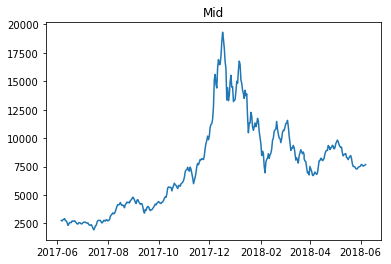

(365,)


In [3]:
mid = ((df.High + df.Low)/2.)
plt.plot(df.Date, mid)
plt.title("Mid")
plt.show()
print mid.shape

## Regressor

In [97]:
days = 10
span = 30

# return the time series till the day before to the day after
def series_creator(X, y=None, length=30, foresee_days=0):
    m = X.shape[0]
    X_n = []
    y_n = []
    for i in xrange(length, (m-foresee_days)):
        X_n.append(X[(i-length):i])
        if y is not None:
            y_n.append(y[i + foresee_days-1])
    
    if y is None:
        return np.vstack((X_n))
    else:
        return np.vstack((X_n)), np.hstack((y_n))
a = np.array([1,   2,  3,  4,  5,  6,  7,  8])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18])
print series_creator(a, y, length=2, foresee_days=4)


(array([[1, 2],
       [2, 3]]), array([16, 17]))


In [98]:
X, y = series_creator(X=mid.values, y=mid, length=span, foresee_days=days) 
print X.shape, y.shape
scaler = MinMaxScaler()
scaler.fit(X)
X_std = scaler.transform(X)

(325, 30) (325,)


In [99]:
X_train_std, X_a, y_train, y_a = train_test_split(X_std, y, test_size=0.30, random_state=42)


X_test_std, X_validation_std, y_test, y_validation = train_test_split(X_a, y_a, test_size=0.5, random_state=42)


print X_train_std.shape, X_validation_std.shape
print y_train.shape, y_validation.shape
generic_x = np.arange(len(y_test))

(227, 30) (49, 30)
(227,) (49,)


In [100]:
reg =  MLPRegressor(algorithm='adam', alpha=0.1, hidden_layer_sizes=(60), random_state=None,
                verbose=False, max_iter=10000, shuffle= False, tol=1e-10, early_stopping=False,
                   momentum=0.9)

In [101]:
def best_finder(ann, tot, mmin=0):
    ft = mmin
    for i in xrange(tot):
        ann.fit(X_train_std, y_train)
        mf = ann.score(X_validation_std, y_validation)
        #print i
        if mf>ft:
            print "better one found:", mf, i
            ft = mf
            my = copy.copy(ann)
    return my

In [102]:
reg = best_finder(reg, 1)
print "final test", reg.score(X_test_std, y_test)

better one found: 0.7128051673961863 0
final test 0.8278691213173202


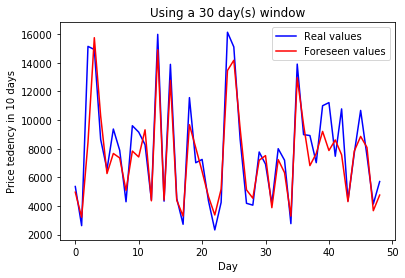

In [103]:
pred = reg.predict(X_test_std)

plt.plot(y_test, c='b', label="Real values")
plt.plot(pred, c='r', label="Foreseen values")
plt.title("Using a %s day(s) window"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()

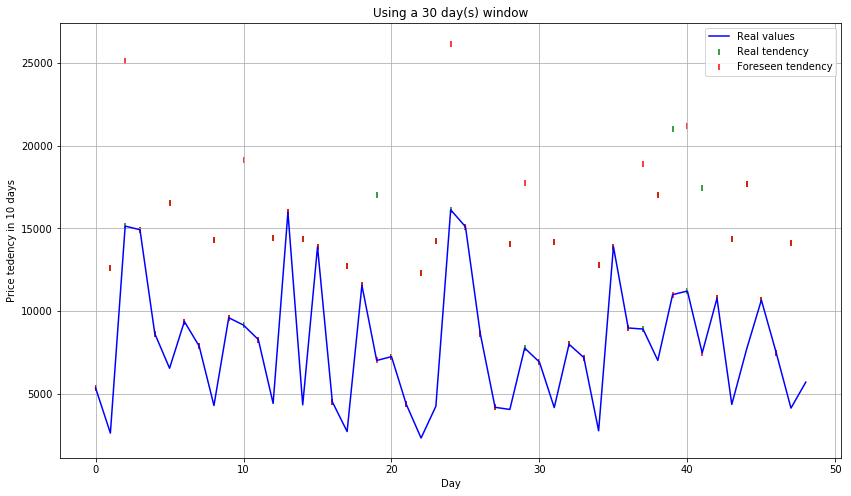

final ac: 82.79%


In [104]:
adj=10000
y_diff = y_test[1:] - y_test[:-1]
y_bin = np.where(1, y_diff>0, 0)
my = y_test[:-1] + adj*y_bin

pred_diff =  pred[1:] - pred[:-1]
pred_bin = np.where(1, pred_diff>0, 0)

my2 = y_test[:-1] + adj*pred_bin
plt.figure(figsize = (14,8))
plt.plot(y_test, c='b', label="Real values")


plt.scatter(generic_x[:-1], my, c='g',marker="|", label="Real tendency")
plt.scatter(generic_x[:-1], my2, c='r',marker="|", label="Foreseen tendency")
plt.grid()

plt.title("Using a %s day(s) window"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()
print "final ac: %.2f%%"%(100*reg.score(X_test_std, y_test))

## Looking the trends (in %)

In [105]:
# return the time series till the day before to the day after, but in % to the previous
def series_creator_percent(X, y=None, length=30, foresee_days=0):
    m = X.shape[0]
    X_n = []
    y_n = []
    for i in xrange(length, (m-foresee_days)):
        X_n.append(X[(i-length):i])
        if y is not None:
            y_n.append(float(y[i + foresee_days-1])/y[i-1] - 1)
            #y_n.append(y[i-1])
    
    if y is None:
        return np.vstack((X_n))
    else:
        return np.vstack((X_n)), np.hstack((y_n))
a = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array([1, 2, 3, 4, 5, 6, 7, 8])
print series_creator_percent(a,y, length=1, foresee_days=1)

(array([[1],
       [2],
       [3],
       [4],
       [5],
       [6]]), array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667]))


In [107]:
X2, y2 = series_creator_percent(X=mid.values, y=mid, length=span, foresee_days=days) 
print X.shape, y.shape
scaler = MinMaxScaler()
scaler.fit(X2)
X_std2 = scaler.transform(X2)



(325, 30) (8,)


In [108]:
X_train_std2, X_a2, y_train2, y_a2 = train_test_split(X_std2, y2, test_size=0.30, random_state=42)


X_test_std2, X_validation_std2, y_test2, y_validation2 = train_test_split(X_a2, y_a2, test_size=0.5, random_state=42)



print X_train_std2.shape, X_validation_std2.shape, X_test_std2.shape
print y_train2.shape, y_validation2.shape, y_test2.shape


(227, 30) (49, 30) (49, 30)
(227,) (49,) (49,)


In [109]:
y_validation_bin = np.where(1, y_validation2>0, 0)
y_test_bin = np.where(1, y_test2>0, 0)
def bin_score(pred, y_bin):
    res = 0
    le = len(pred)
    pred_bin = np.where(1, pred>0, 0)
    for i in xrange(le):
        if y_bin[i]==pred_bin[i]:
            res +=1
    return float(res)/le


def best_finder_b(ann, tot, mmin=0):
    ft = mmin
    for i in xrange(tot):
        ann.fit(X_train_std2, y_train2)
        pred = ann.predict(X_validation_std2)
        mf = bin_score(pred, y_validation_bin)
        #print i
        if mf>ft:
            print "better one found:", mf, i
            ft = mf
            my = copy.copy(ann)
    return my

### Seeing tendencies in the binariazation of the regressor

In [110]:
#reg.fit(X_train_std, y_train)
reg2 = best_finder_b(reg, 300, 0.5)
print reg2.score(X_test_std2, y_test2)
pred2 = reg2.predict(X_test_std2)
print "Accuracy for binarization", bin_score(pred2, y_test_bin)
pred_bin = np.where(1, pred2>0, 0)


better one found: 0.69387755102 0
better one found: 0.714285714286 8
better one found: 0.734693877551 88
better one found: 0.755102040816 174
0.07066900371757512
Accuracy for binarization 0.714285714286


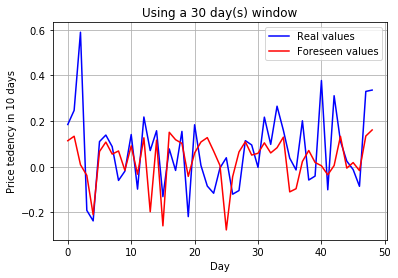

In [111]:
plt.plot(y_test2, c='b', label="Real values")
plt.plot(pred2, c='r', label="Foreseen values")
plt.xlabel("Day")
plt.grid()
plt.title("Using a %s day(s) window"%span)
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()

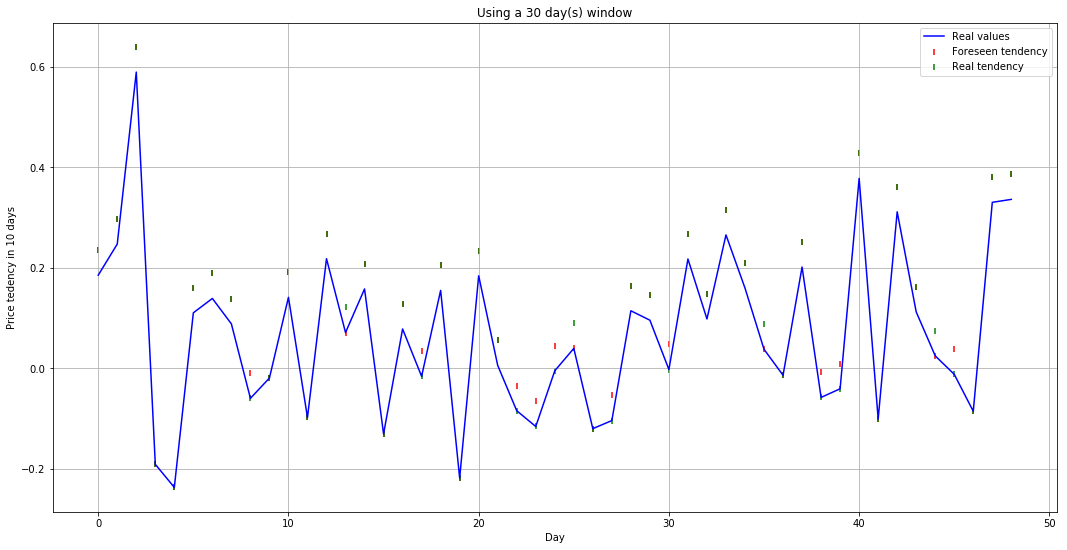

In [112]:

v = y_test2 + pred_bin/20.
v1 = y_test2 + y_test_bin/20.

plt.figure(figsize = (18,9))
plt.plot(generic_x, y_test2, c='b', label="Real values")

plt.scatter(generic_x, v, c="r", marker="|", label="Foreseen tendency")
plt.scatter(generic_x, v1, c='g', marker="|", label="Real tendency")

plt.xlabel("Day")
plt.grid()
plt.title("Using a %s day(s) window"%span)
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')

plt.show()

## N days series


In [113]:
# return the time series till the day before to the day after
def series_creator_ndays(X, y=None, length=30, foresee_days=0):
    m = X.shape[0]
    X_n = []
    y_n = []
    for i in xrange(length, (m-foresee_days)):
        X_n.append(X[(i-length):i])
        if y is not None:
            y_n.append(y[i-1:i + foresee_days-1])
    
    if y is None:
        return np.vstack((X_n))
    else:
        return np.vstack((X_n)), np.vstack((y_n))
a = np.array([1,   2,  3,  4,  5,  6,  7,  8])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18])
print series_creator_ndays(a, y, length=1, foresee_days=2)


(array([[1],
       [2],
       [3],
       [4],
       [5]]), array([[11, 12],
       [12, 13],
       [13, 14],
       [14, 15],
       [15, 16]]))


In [114]:
X3, y3 = series_creator_ndays(X=mid.values, y=mid, length=span, foresee_days=days) 
print X3.shape, y3.shape
scaler = MinMaxScaler()
scaler.fit(X3)
X_std3 = scaler.transform(X)

(325, 30) (325, 10)


In [115]:
X_train_std3, X_a3, y_train3, y_a3 = train_test_split(X_std3, y3, test_size=0.30, random_state=42)


X_test_std3, X_validation_std3, y_test3, y_validation3 = train_test_split(X_a3, y_a3, test_size=0.5, random_state=42)


print X_train_std3.shape, X_validation_std3.shape
print y_train3.shape, y_validation3.shape
generic_x = np.arange(len(y_test))

(227, 30) (49, 30)
(227, 10) (49, 10)


In [116]:
def best_finder(ann, tot, mmin=0):
    ft = mmin
    for i in xrange(tot):
        ann.fit(X_train_std3, y_train3)
        mf = ann.score(X_validation_std3, y_validation3)
        #print i
        if mf>ft:
            print "better one found:", mf, i
            ft = mf
            my = copy.copy(ann)
    return my

In [120]:
reg = best_finder(reg, 3)
print "final test", reg.score(X_test_std3, y_test3)

better one found: 0.8464468158900426 0
better one found: 0.8472341058456856 1
better one found: 0.8473242253787443 2
final test 0.8999784150174326


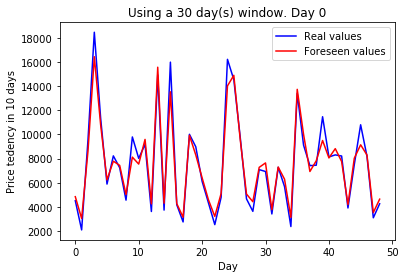

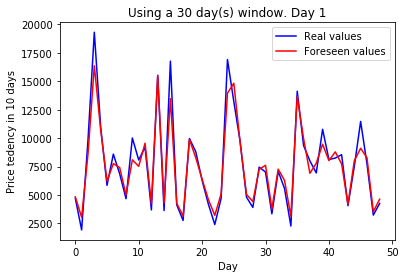

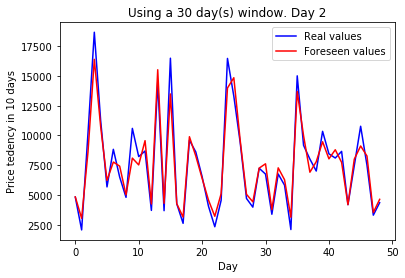

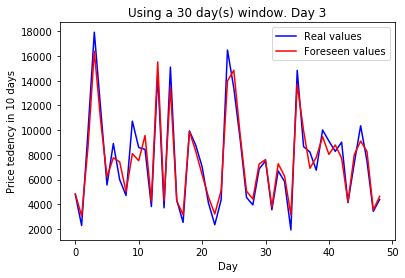

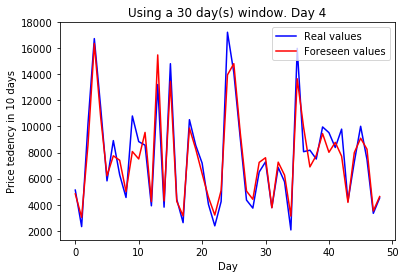

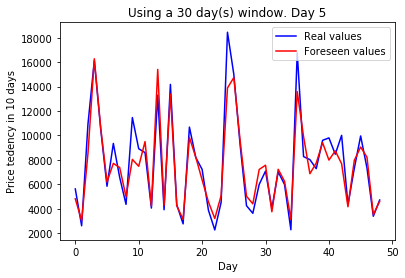

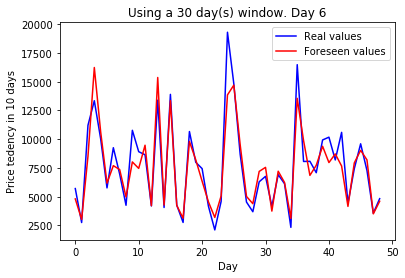

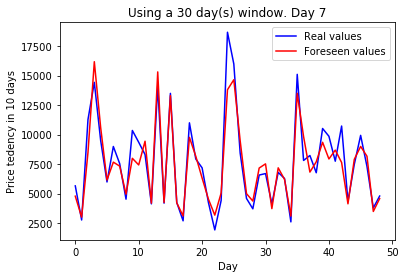

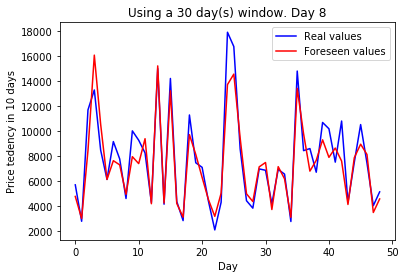

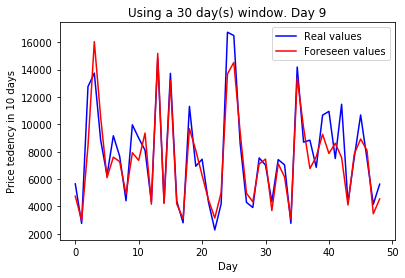

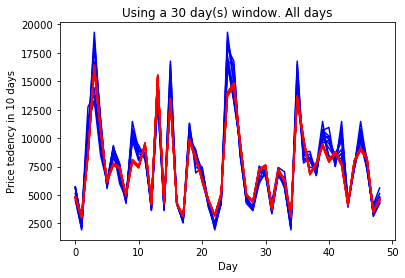

In [121]:
pred3 = reg.predict(X_test_std3)

for i in xrange(days):
    plt.plot(y_test3[:,i], c='b', label="Real values")
    plt.plot(pred3[:, i], c='r', label="Foreseen values")
    plt.title("Using a %s day(s) window. Day %s"%(span, i))
    plt.xlabel("Day")
    plt.ylabel("Price tedency in %s days"%days)
    plt.legend(loc='best')
    plt.show()
    
plt.plot(y_test3, c='b')
plt.plot(pred3, c='r')
plt.title("Using a %s day(s) window. All days"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)

plt.show()

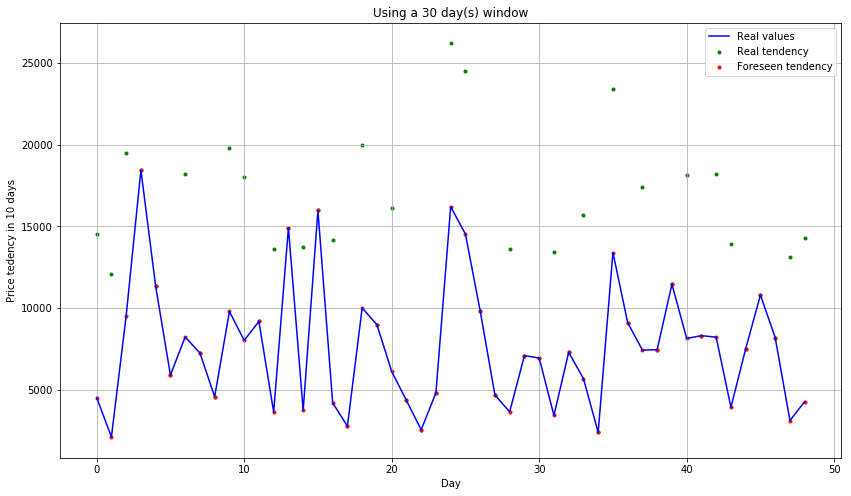

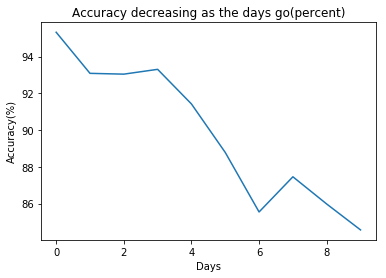

In [123]:
adj=10000
f = 6
i = 0

y_diff = y_test3[:, f] - y_test3[:, i]

y_bin = np.where(1, y_diff>0, 0)

my = y_test3[:,i] + adj*y_bin

pred_diff =  pred3[:, f] - pred3[:, i]
pred_bin = np.where(1, pred_diff>0, 0)

my2 = y_test3[:, i] + adj*pred_bin
plt.figure(figsize = (14,8))
plt.plot(y_test3[:,i], c='b', label="Real values")


plt.scatter(generic_x, my, c='g',marker=".", label="Real tendency")
plt.scatter(generic_x, my2, c='r',marker=".", label="Foreseen tendency")
plt.grid()

plt.title("Using a %s day(s) window"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()

ac = []
for i in xrange(days):
    ac.append(100*r2_score(y_test3[:, i], pred3[:,i]))
    #print "day %s ac: %.2f%%"%(i, ac[i] )
plt.plot(ac)
plt.title("Accuracy decreasing as the days go(percent)")
plt.xlabel("Days")
plt.ylabel("Accuracy(%)")
plt.show()
